In [ ]:
import pandas as pd
from keras.models import Model
from keras.layers import Input,Dense,SimpleRNN,Activation
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,MaxPooling1D,Activation,Flatten, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

import sys

#keras.tunner

In [ ]:
ds_train = tfds.load('snli',split='train[20%:]',shuffle_files=True)
ds_valid = tfds.load('snli',split='validation',shuffle_files=False)
ds_test = tfds.load('snli',split='test',shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete20R6CB/snli-test.tfrecord*...:   0%|          | 0/10000 […

Generating validation examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete20R6CB/snli-validation.tfrecord*...:   0%|          | 0/1…

Generating train examples...:   0%|          | 0/550152 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/snli/1.1.0.incomplete20R6CB/snli-train.tfrecord*...:   0%|          | 0/550152…

Dataset snli downloaded and prepared to ~/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


In [ ]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [ ]:
aux=[]
for i in range(len(df_train['hypothesis'])):
  aux.append(df_train['hypothesis'][i].decode("utf-8") + ' ' + df_train['premise'][i].decode("utf-8"))

df_train = df_train.drop(['hypothesis','premise'], axis=1)
df_train['text'] = aux

In [ ]:
df_train.head()

,label,text
0,0,"There is one man in this picture, and he is ou..."
1,0,Some people are sitting while others are stand...
2,1,A person began to cry as they were giving a sp...
3,2,The man is wearing a black overcoat. A man in ...
4,0,A person is sweeping. A man in a white and blu...


In [ ]:
aux=[]
for i in range(len(df_valid['hypothesis'])):
  aux.append(df_valid['hypothesis'][0].decode("utf-8") + ' ' + df_valid['premise'][0].decode("utf-8"))

df_valid = df_valid.drop(['hypothesis','premise'], axis=1)
df_valid['text'] = aux

In [ ]:
aux=[]
for i in range(len(df_test['hypothesis'])):
  aux.append(df_test['hypothesis'][0].decode("utf-8") + ' ' + df_test['premise'][0].decode("utf-8"))

df_test = df_test.drop(['hypothesis','premise'], axis=1)
df_test['text'] = aux

In [ ]:
print(f'Train size {df_train.shape}')
print(f'Valid size {df_valid.shape}')
print(f'Test size {df_test.shape}')

Train size (440122, 2)
Valid size (10000, 2)
Test size (10000, 2)


In [ ]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

In [ ]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [ ]:
train_tweets = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [ ]:
vocab_size = len(vocabulary)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['text'])

In [ ]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])


In [ ]:
max_words = 113

hist = {}

hist['qtde'] = [x for x in range(0,max_words)]
y=0
z=1000
lista = [0]*(max_words)
for x in train_sequences:
    lista[len(x)]+=1


hist['num tweets'] = lista

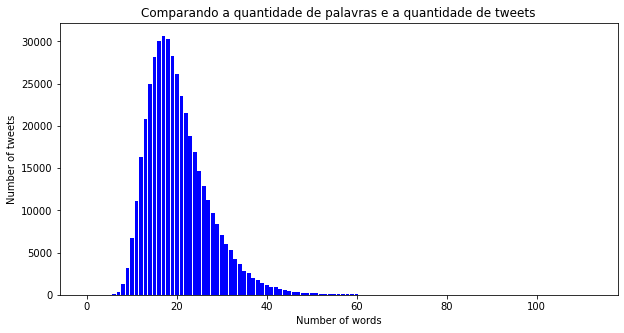

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hist['qtde'],hist['num tweets'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
plt.title("Comparando a quantidade de palavras e a quantidade de tweets")
plt.show()

In [ ]:
max_length = 64
trunc_type = 'post'
padding_type = 'post'

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
print(f"Tweet: {df_train['text'][0]}")
print('Tweet numericalizado: ')
print(train_sequences[0])
print(f'Quantidade de palavras no tweet: {len(train_sequences[0])}')

Tweet: There is one man in this picture, and he is outside. An older gentleman with a gray mustache sitting on a stool in front of a small table in front of a business.
Tweet numericalizado: 
[48, 4, 46, 5, 3, 213, 104, 7, 131, 4, 38, 17, 135, 567, 10, 1, 143, 1445, 28, 6, 1, 1222, 3, 41, 9, 1, 77, 90, 3, 41, 9, 1, 590]
Quantidade de palavras no tweet: 33


In [ ]:
n = 64

embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=4,output_dim = n))

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = n, input_length=max_length))
model.add(SimpleRNN(128,return_sequences=True,activation='relu'))
model.add(Dropout(0.5))
model.add(SimpleRNN(64,return_sequences=True,activation='relu'))
model.add(Dropout(0.5))
model.add(SimpleRNN(32,activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 64)            3372992   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64, 128)           24704     
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64, 64)            12352     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 4)                

In [ ]:
max_length = 64

In [ ]:
trunc_type = 'post'
padding_type = 'post'

In [ ]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),epochs=10)

Epoch 1/10
13754/13754 [==============================] - 2252s 163ms/step - loss: 1.1111 - accuracy: 0.3327 - val_loss: 1.1791 - val_accuracy: 0.3235
Epoch 2/10
13754/13754 [==============================] - 2242s 163ms/step - loss: 1.1087 - accuracy: 0.3327 - val_loss: 1.1855 - val_accuracy: 0.3329
Epoch 3/10
13754/13754 [==============================] - 2251s 164ms/step - loss: 1.1084 - accuracy: 0.3329 - val_loss: 1.1839 - val_accuracy: 0.3329
Epoch 4/10
13754/13754 [==============================] - 2247s 163ms/step - loss: 1.1083 - accuracy: 0.3336 - val_loss: 1.1840 - val_accuracy: 0.3278
Epoch 5/10
13754/13754 [==============================] - 2254s 164ms/step - loss: 1.1082 - accuracy: 0.3337 - val_loss: 1.1872 - val_accuracy: 0.3329
Epoch 6/10
13754/13754 [==============================] - 2251s 164ms/step - loss: 1.1082 - accuracy: 0.3325 - val_loss: 1.1879 - val_accuracy: 0.3235
Epoch 7/10
13754/13754 [==============================] - 2275s 165ms/step - loss: 1.1081 - ac

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [ ]:
print(classification_report(y_test_int,y_pred))